<a href="https://colab.research.google.com/github/tronghieu2810/DEEP-LEARNING/blob/main/UDEMY/%5BMike_X_Cohen%5D_Deep_understanding/CNN/DUDL_CNN_CodeChallengeLinearUnits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

# summary info on models
from torchsummary import summary

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

In [2]:
# Use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Create Gaussian blurs with different widths

In [3]:
n_per_class = 1000 # Total 2000 images
img_size    = 91

x    = np.linspace(start=-4, stop=4, num=img_size)
X, Y = np.meshgrid(x, x)

# The two widths (a.u.) sigma
widths = [1.8, 2.4]

# Initialize tensors containing images and labels
images = torch.zeros(2 * n_per_class, 1, img_size, img_size)
labels = torch.zeros(2 * n_per_class)

for i in range(2 * n_per_class):
    
    # Create the gaussian with random centers
    # Ro = random offset
    # `i % 2`: Even image belong to label 0
    ro = 2 * np.random.randn(2)
    G  = np.exp(-((X - ro[0]) ** 2 + (Y - ro[1]) ** 2) / (2 * widths[i % 2] ** 2))
    
    # And add noise
    G += np.random.randn(img_size, img_size) / 5
    
    # Add to the tensor
    # `.view`: Convert from numpy matrix to PTorch Tensor
    images[i, :, :, :] = torch.tensor(G).view(1, img_size, img_size)
    labels[i]          = i % 2

labels = labels[:, None]

# Create train/test groups using DataLoader

In [4]:
# Use scikitlearn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(images, labels, test_size=0.1)

# Convert into PyTorch Datasets
train_data_set = TensorDataset(train_data, train_labels)
test_data_set  = TensorDataset(test_data, test_labels)

# Translate into Dataloader objects
batch_size   = 32
train_loader = DataLoader(dataset=train_data_set, batch_size=batch_size,
                        shuffle=True, drop_last=True)
test_loader  = DataLoader(dataset=test_data_set, 
                        batch_size=test_data_set.tensors[0].shape[0])

# Create the DL model

In [5]:
def make_the_net(fc_units):
    """
    CNN_LINEAR_UNITS
    """
    class gauss_net(nn.Module):
        def __init__(self):
            super().__init__()
            
            # All layers in one go using nn.Sequential
            self.enc = nn.Sequential(
                nn.Conv2d(1, 6, kernel_size=3, padding=1),  # (91 + 2*1 -3)/1 + 1 = 91
                nn.ReLU(),                                  # Treated like a "layer"
                nn.AvgPool2d(2, 2),                         # 91 / 2 = 45
                
                
                nn.Conv2d(6, 4, kernel_size=3, padding=1),  # (45 +2*1 -3)/1 + 1 = 45
                nn.ReLU(),
                nn.AvgPool2d(2, 2),                         # 45 / 2 = 22
                
                nn.Flatten(),                               # Vectorize conv output
                nn.Linear(22 * 22 * 4, 2 * fc_units),       
                nn.Linear(2 * fc_units, fc_units),
                nn.Linear(fc_units, 1)                            # 1
            )
        
        def forward(self, x):
            return self.enc(x)
        
    
    # Create the model instance
    net = gauss_net()
    
    # Loss Function
    loss_func = nn.BCEWithLogitsLoss()
    
    # Optimizer
    optimizer = torch.optim.Adam(params=net.parameters(), lr=0.001)
    
    return net, loss_func, optimizer

# Create a function that trains the model

In [9]:
def train_the_model(fc_units):
    """
    CNN_LINEAR_UNITS
    """
    
    num_epochs = 10

    # Create a new model
    net, loss_func, optimizer = make_the_net(fc_units)

    # Send the model to the GPU
    net.to(device)

    # Initialize
    train_loss = torch.zeros(num_epochs)
    test_loss  = torch.zeros(num_epochs)
    train_acc  = torch.zeros(num_epochs)
    test_acc   = torch.zeros(num_epochs)

    # Loop over epochs
    for epoch_i in range(num_epochs):

        # Loop over training data batches
        batch_acc  = []
        batch_loss = [] 

        for X, y in train_loader:
            # Push data to GPU
            X = X.to(device)
            y = y.to(device)

            # Forward pass and loss
            y_hat = net(X)
            loss  = loss_func(y_hat,y)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Loss from this batch
            batch_loss.append(loss.item())
            batch_acc .append(torch.mean(((y_hat > 0) == y).float()).item())

        # End of batch loop.

        # Get the average training accuracy of the batches
        train_loss[epoch_i] = np.mean(batch_loss)
        train_acc [epoch_i] = 100 * np.mean(batch_acc)

        # Test accuracy
        X, y = next(iter(test_loader)) # Extract X, y from dataloader
        
        # Push data to GPU
        X = X.to(device)
        y = y.to(device)

        with torch.no_grad():
            y_hat = net(X)
            loss  = loss_func(y_hat, y)
            
        test_loss[epoch_i] = loss.item()
        test_acc [epoch_i] = 100 * torch.mean(((y_hat > 0) == y).float()).item()

    # End epochs

    return train_loss, test_loss, train_acc, test_acc, net

# Run the model and show the results!

In [11]:
# Number of hidden units
number_of_linear_units = np.round(np.linspace(5, 500, 20))

# Initialize results matrix
results = np.zeros((len(number_of_linear_units), 4))

for units_idx, units_i in enumerate(number_of_linear_units):
    train_loss, test_loss, train_acc, test_acc, net = train_the_model(fc_units=int(units_i))
    results[units_idx, :] = [train_loss[-1], test_loss[-1], train_acc[-1], test_acc[-1]] 

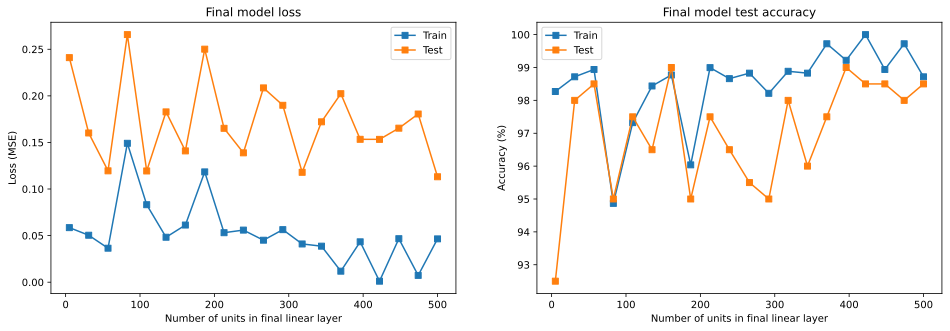

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(number_of_linear_units, results[:, :2], 's-')
ax[0].set_xlabel('Number of units in final linear layer')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Final model loss')
ax[0].legend(['Train', 'Test'])

ax[1].plot(number_of_linear_units, results[:, 2:], 's-')
ax[1].set_xlabel('Number of units in final linear layer')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title('Final model test accuracy')
ax[1].legend(['Train', 'Test'])

plt.show()